<a href="https://colab.research.google.com/github/tbazzi/Data-Science---Fullstack-Bootcamp/blob/master/S7_2_1_Cifar10_with_ResNet50_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cifar10 with MobileNet 

Nous avons vu comment classer des images du dataset Cifar10 avec une structure de CNN qu'on a créé à la main. Nous allons voir comment on peut améliorer nos résultats avec un MobileNet 

* Importez :
  * Tensorflow 2.0
  * Numpy 
  * Matplotlib.pyplot 

In [0]:
!pip install tensorflow-gpu==2.0.0beta1
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 

     |████████████████████████████████| 348.9MB 79kB/s 
     |████████████████████████████████| 501kB 38.2MB/s 
     |████████████████████████████████| 3.1MB 30.9MB/s 


* En utilisant [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) importez cifar10 et stockez les données dans `X_train, y_train, X_test, y_test`

In [0]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train),(X_test, y_test) = cifar10.load_data()

* Visualisez une image aléatoire de votre dataset 

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[1]')

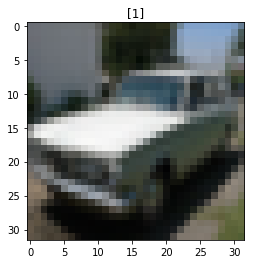

In [0]:
# Visualisation d'une image aléatoire
import matplotlib.pyplot as plt 
import numpy as np

random_image = np.random.randint(100)
plt.imshow(X_train[random_image])
plt.title(y_train[random_image])

* Visualisez une image aléatoire de chacun de vos labels dans votre dataset 

index for each image :[0 1 2 3 4 5 6 7 8 9]


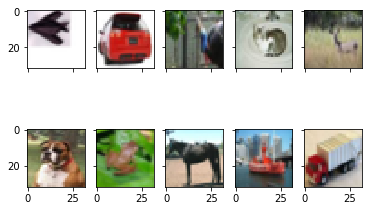

In [0]:
def visualize_random_img_for_each_target(X ,y, nrows, ncols):
  
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
  
  random_image = np.random.randint(100)
  
  index = nrows + ncols
  for row in range(nrows):
    for col in range(ncols):
      mask = y == nrows + ncols - index
      mask = mask.squeeze()
      axes[row, col].imshow(X[mask][random_image])
      index -=1 


  print("index for each image :{}".format(np.unique(y)))

visualize_random_img_for_each_target(X_train,y_train, 2, 5)

* Nous allons procéder à une partie de _data augmentation_. En utilisant [`tf.keras.preprocessing.image.ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), appliquez les choses suivantes : 
  * Flip horizontal aléatoire 
  * Shear_range à 0.2
  * Zoom_range à 0.2
  * Rescale à 1/255.0

In [0]:
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    data_format="channels_last",
    rescale=1.0/255.0
)

In [0]:
data_aug.fit(X_train)

* Regardez que vous ayez bien fitté vos images sur votre `X_train` et tentez de regarder la _shape_ d'un set de données 

In [0]:
next(iter(data_aug.flow(X_train, y_train, batch_size=1)))[0].shape

(1, 32, 32, 3)

* Visualisez une image aléatoire après avoir fait votre _data augmentation_ pour vérifier que tout s'est bien passé 

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[[0]]')

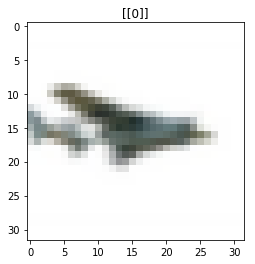

In [0]:
img, target = next(iter(data_aug.flow(X_train, y_train, batch_size=1)))
plt.imshow(img.reshape(32,32,3))
plt.title(target)

* Nous allons maintenant créer notre modèle. Pour cela, nous allons importer `ResNet`. Pour ce faire : 
  * Utilisez `tf.keras.applications.Resnet50`
  * N'oubliez pas de pas inclure la dernière couche 
  * Ajoutez y les poids de "imagenet"

In [0]:
base_model = tf.keras.applications.ResNet50(input_shape=(32,32,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step


* Regardez les couches de votre modèle en utilisant `model.summary()`

In [0]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

* Gelez toutes les couches de votre modèle 

In [0]:
base_model.trainable = False

* Ajoutez la dernière couche de votre modèle pour l'adapter à votre dataset 

In [0]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation="softmax")
])

* Créez une _Learning Rate Schedule_. Vous pouvez choisir de le faire avec [_ExponentialDecay_](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) ou [d'autres méthodes](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules)

In [0]:
# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.0005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=6000,
    decay_rate=0.95,
    staircase=True)

* Créez un compileur dans lequel vous choisirez : 
  * Votre optimiseur 
  * Votre loss 
  * Vos métrics 

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

* Faites tourner votre modèle sur 5 epochs 

In [0]:
model.fit_generator(data_aug.flow(X_train, y_train, batch_size=16), epochs=5)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
3125/3125 [==============================] - 137s 44ms/step - loss: 1.9398 - sparse_categorical_accuracy: 0.3708
Epoch 2/5
3125/3125 [==============================] - 126s 40ms/step - loss: 1.7327 - sparse_categorical_accuracy: 0.4221
Epoch 3/5
3125/3125 [==============================] - 119s 38ms/step - loss: 1.6885 - sparse_categorical_accuracy: 0.4322
Epoch 4/5
3125/3125 [==============================] - 118s 38ms/step - loss: 1.6755 - sparse_categorical_accuracy: 0.4352
Epoch 5/5
3125/3125 [==============================] - 117s 38ms/step - loss: 1.6744 - sparse_categorical_accuracy: 0.4378


* Evaluez votre modèle grâce à [`model.evaluate_generator`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate_generator)

In [0]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 11s 1ms/sample - loss: 4.0999 - sparse_categorical_accuracy: 0.2235


[4.0998666847229, 0.2235]

* Regardez le nombre de layers que vous avez dans votre modèle 

In [0]:
len(base_model.layers)

175

* Notre modèle pourrait donner des meilleurs scores si nous débloquions quelques couches. Débloquez les 150 dernières couches.

In [0]:
base_model.trainable = True
fine_tune_at = 125
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

* Tentez d'entrainer votre modèle à nouveau. Cette fois cependant : 
  * Ajoutez l'argument *validation_data = (X_test, y_test)*  
  * Profitez en pour enregistrer votre entrainement dans une variable _history_
  
* Que pouvez vous conclure sur votre modèle ?

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

In [0]:
# Notre modèle overfit beaucoup. 
# Il est fort possible qu'il soit trop complexe pour notre problématique
history = model.fit_generator(data_aug.flow(X_train, y_train, batch_size=16), 
                             epochs=5,
                             validation_data = (X_test, y_test))

Epoch 1/5
3125/3125 [==============================] - 325s 104ms/step - loss: 1.5563 - sparse_categorical_accuracy: 0.5058 - val_loss: 2.8164 - val_sparse_categorical_accuracy: 0.3883
Epoch 2/5
3125/3125 [==============================] - 308s 98ms/step - loss: 1.6516 - sparse_categorical_accuracy: 0.5436 - val_loss: 3.3642 - val_sparse_categorical_accuracy: 0.4028
Epoch 3/5
3125/3125 [==============================] - 309s 99ms/step - loss: 1.2811 - sparse_categorical_accuracy: 0.5880 - val_loss: 2.6486 - val_sparse_categorical_accuracy: 0.4101
Epoch 4/5
3125/3125 [==============================] - 305s 98ms/step - loss: 1.2374 - sparse_categorical_accuracy: 0.6061 - val_loss: 2.9080 - val_sparse_categorical_accuracy: 0.4023
Epoch 5/5
3125/3125 [==============================] - 307s 98ms/step - loss: 1.1950 - sparse_categorical_accuracy: 0.6157 - val_loss: 2.7582 - val_sparse_categorical_accuracy: 0.4288


* Regardez ce qu'il y a dans `history.history`

In [0]:
history.history

{'loss': [1.5563063564872741,
  1.6516220891952516,
  1.2810976841831208,
  1.237397425327301,
  1.1950485583782195],
 'sparse_categorical_accuracy': [0.50576, 0.54356, 0.58796, 0.60606, 0.61572],
 'val_loss': [2.8163576818466187,
  3.3641551239967344,
  2.648570831680298,
  2.9079515562057496,
  2.7582400037765504],
 'val_sparse_categorical_accuracy': [0.3883, 0.4028, 0.4101, 0.4023, 0.4288]}

* Regardez maintenant un graphique de l'évolution de votre *loss*  à mesure que les epochs avancent  

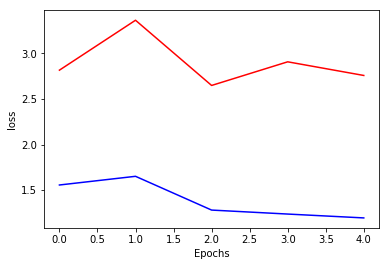

In [0]:
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

* Faites de même avec votre Accuracy 

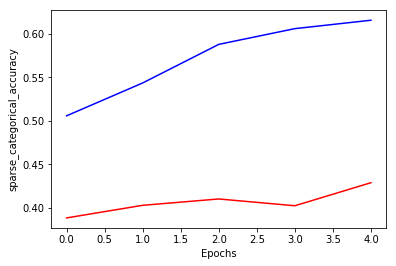

In [0]:
plt.plot(history.history["sparse_categorical_accuracy"], color="b")
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("sparse_categorical_accuracy")
plt.xlabel("Epochs")
plt.show()

In [0]:
model.fit?